### Summary: Generating Text with an Autoregressive Model

This notebook explores building an autoregressive text generation model, also known as a **Markov Model**, to generate text in the style of a given book. The lab begins by preprocessing text data from **Project Gutenberg**, using works like _Alice in Wonderland_ and _The Metamorphosis_, and sets up an autoregressive model where the probability of the next word is based on the previous $k$ words (k-gram). The goal is to balance grammatical structure while avoiding excessive copying from the source material.

Key components of the lab include:
- **Data Preprocessing**: Downloading and cleaning text from multiple books, preparing it for modeling by tokenizing and structuring sequences based on $k$-grams.
- **Model Implementation**: Constructing and training the autoregressive model to predict the next word based on the $k$ most recent words, demonstrating the impact of $k$ on the quality of generated text.
- **Quality vs. Plagiarism Trade-off**: Analyzing how smaller values of $k$ generate less coherent text, while larger values result in plagiarism as the model copies large text chunks from the original work. Experiments include measuring the **Longest Common Substring (LCS)** between generated and original text across different $k$ values.
- **Visualization and Evaluation**: Plotting LCS lengths to show how text similarity scales with $k$ and exploring the exponential growth in copying as $k$ increases. 
- **Model Improvement Challenge**: A bonus task invites modifications to the $k$-gram model, encouraging creativity to balance coherence and originality.

This hands-on lab provides a foundational understanding of probabilistic models for text generation and highlights the challenges and trade-offs involved in building language models.


Import libraries

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')

Preprocessing the text data

In [17]:
#Code adapted from https://pypi.org/project/Gutenberg/ to help download from
#Project Gutenberg (www.gutenberg.org/) automatically. 
def _format_download_urls(etextno):
    """
    Returns the possible urls location on the Project Gutenberg servers for a
    given text. Mostly ripped from https://pypi.org/project/Gutenberg/.
    """
    uri_root = r'http://www.gutenberg.lib.md.us'

    if 0 < etextno < 10:
        oldstyle_files = (
            'when11',
            'bill11',
            'jfk11',
            'getty11',
            'const11',
            'liber11',
            'mayfl11',
            'linc211',
            'linc111',
        )
        etextno = int(etextno)
        return '{root}/etext90/{name}.txt'.format(
            root=uri_root,
            name=oldstyle_files[etextno - 1])

    else:
        etextno = str(etextno)
        extensions = ('.txt', '-8.txt', '-0.txt')
        urls = []
        for extension in extensions:
            uri = '{root}/{path}/{etextno}/{etextno}{extension}'.format(
                root=uri_root,
                path='/'.join(etextno[:len(etextno) - 1]),
                etextno=etextno,
                extension=extension)
            urls.append(uri)
        return urls
    
def download_from_book_id(bookid, bookname):

    book_dst = f'{bookname}.txt'
    
    import os
    from six.moves import urllib
    
    if os.path.isfile(book_dst):
      print('File %s is already downloaded' % book_dst)
    else:
      possible_urls = _format_download_urls(bookid)
      print(possible_urls)
      for url in possible_urls:
        print(f'trying {url}...')
        try:
          urllib.request.urlretrieve(url, book_dst)
          print(f'Downloaded {bookname}.txt, with book id {bookid}.')
          return
        except urllib.error.HTTPError:
          None
      raise NameError("Couldn't find that book on Gutenberg")

In [18]:
#downloading the books we'll use for the lab
download_from_book_id(100, "Shakespeare")
download_from_book_id(5200, "Metamorphosis")
download_from_book_id(11, "Wonderland")
download_from_book_id(1184, "MonteCristo")

File Shakespeare.txt is already downloaded
File Metamorphosis.txt is already downloaded
File Wonderland.txt is already downloaded
File MonteCristo.txt is already downloaded


In [19]:
# inspecting one of the books to get a sense of the content of the files
file_handle = open("Wonderland.txt", encoding="utf8")  # It's very important to mention utf8 encoding
wonderland_book_text = file_handle.read()  # Copies the book as a string in memory
file_handle.close()

print(wonderland_book_text[0:1000])

*** START OF THE PROJECT GUTENBERG EBOOK 11 ***
[Illustration]




Alice’s Adventures in Wonderland

by Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0

Contents

 CHAPTER I.     Down the Rabbit-Hole
 CHAPTER II.    The Pool of Tears
 CHAPTER III.   A Caucus-Race and a Long Tale
 CHAPTER IV.    The Rabbit Sends in a Little Bill
 CHAPTER V.     Advice from a Caterpillar
 CHAPTER VI.    Pig and Pepper
 CHAPTER VII.   A Mad Tea-Party
 CHAPTER VIII.  The Queen’s Croquet-Ground
 CHAPTER IX.    The Mock Turtle’s Story
 CHAPTER X.     The Lobster Quadrille
 CHAPTER XI.    Who Stole the Tarts?
 CHAPTER XII.   Alice’s Evidence




CHAPTER I.
Down the Rabbit-Hole


Alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into
the book her sister was reading, but it had no pictures or
conversations in it, “and what is the use of a book,” thought Alice
“without pictures or conversations?”

So she was considering in her 

writing a function to convert the files into strings of one word length, only taking the actual book content and dropping the metadata at the beginning and end of the files

In [20]:
def word_sequence_from_file(filepath):

    # Open the file
    file_handle = open(filepath, encoding="utf8")
    raw_book_text = file_handle.read()  # Copies the book as a string in memory
    file_handle.close()

    start = '*** START OF THE PROJECT GUTENBERG EBOOK'
    end = '*** END OF THE PROJECT GUTENBERG EBOOK'
    
    startInd = raw_book_text.find(start) + len(start)
    endInd = raw_book_text.find(end) + len(end)
    
    book_text = raw_book_text[startInd:endInd+1]
    word_sequence = book_text.split()

    return word_sequence

In [21]:
# converting the books into word sequence lists
shakespeare = word_sequence_from_file("Shakespeare.txt")
metamorphosis = word_sequence_from_file("Metamorphosis.txt")
wonderland = word_sequence_from_file("Wonderland.txt")
montecristo = word_sequence_from_file("MonteCristo.txt")

In [22]:
#printing the first 100 words of the wonderland book to test the function
display(" ".join(wonderland[1:100]))

'*** [Illustration] Alice’s Adventures in Wonderland by Lewis Carroll THE MILLENNIUM FULCRUM EDITION 3.0 Contents CHAPTER I. Down the Rabbit-Hole CHAPTER II. The Pool of Tears CHAPTER III. A Caucus-Race and a Long Tale CHAPTER IV. The Rabbit Sends in a Little Bill CHAPTER V. Advice from a Caterpillar CHAPTER VI. Pig and Pepper CHAPTER VII. A Mad Tea-Party CHAPTER VIII. The Queen’s Croquet-Ground CHAPTER IX. The Mock Turtle’s Story CHAPTER X. The Lobster Quadrille CHAPTER XI. Who Stole the Tarts? CHAPTER XII. Alice’s Evidence CHAPTER I. Down the Rabbit-Hole Alice was beginning to get very tired of sitting'

To build the model, we need to create an autoregressive model that uses a probabilistic approach to predict the next word in a sequence based on the previous $k$ words. The model will be trained on the text data from one of the books we downloaded. We will use a dictionary to store the probabilities of each word given the previous $k$ words. The model will generate text by predicting the next word based on the last $k$ words and then updating the sequence to include the new word. 

In [23]:
# create a dictionary that stores the probabilities of each word given the previous k words
def make_freq_dict(k, word_sequence):

    # Make empty dict to count frequencies
    freq_dict = dict()

    #loop through all k-grams
    for i in range(len(word_sequence) - k -1):
        Kgram = " ".join(word_sequence[i:i+k])
        Next = word_sequence[i+k]
        
        if Kgram in freq_dict:
            if Next in freq_dict[Kgram]:
                freq_dict[Kgram][Next] += 1
            else:
                freq_dict[Kgram][Next] = 1
        else:
            freq_dict[Kgram] = {Next: 1}

    return freq_dict

In [24]:
#function to predict the next word given a frequency dictionary and a k-gram of words
def predict_next_word(this_kgram, freq_dict):
    
    if this_kgram not in freq_dict:
        return None
    else:
        total = 0
        nextWordOptions = []
        prob = []
        #find probability of each possible next word  
        for nextWord, count in freq_dict[this_kgram].items():
            total += count
        for nextWord,count in freq_dict[this_kgram].items():
            nextWordOptions.append(nextWord)
            prob.append(count/total)
        return random.choices(nextWordOptions, weights = prob, k = 1)[0]

In [25]:
# function to predict a full paragraph of text given a frequency dictionary and an initial k-gram of words selected from the text

def predict_paragraph(start_kgram, k, freq_dict, gen_length=300):

    gen_para = list(start_kgram)
    currKgram = " ".join(start_kgram)
    for i in range(gen_length-k):
        nextWord = predict_next_word(currKgram, freq_dict)
        
        #make sure there is a next word to append to the paragraph
        if nextWord is None:
            break
        gen_para.append(nextWord)
        currKgram = " ".join(gen_para[-k:])

    return gen_para

In [26]:
# test the code generating a paragraph of text from The Metamorphosis

# Pick k and make a frequency dictionary from Metamorphosis.
k_test = 3

freq_dict_test = make_freq_dict(k_test, metamorphosis)

# pick a random starting k-gram from the freq-dict.
start_test = random.choice(list(freq_dict_test.keys())).split()

# Alternatively, pick the start of the book as the first k-gram
# start_test = metamorphosis[0:k_test]

# Generate a paragraph, and print it.
gen_paragraph = predict_paragraph(start_test, k_test, freq_dict_test)
" ".join(gen_paragraph)

'as he sat reading a number of different newspapers. On the wall exactly opposite there was photograph of Gregor when he was in the dark again, they would sit in the next room had her arms round the chest, pushing and pulling at it from side to side as he peered out at the others. Meanwhile the day had become much calmer. So they couldn’t understand his words any more, although they seemed clear enough to him, clearer than before—perhaps his ears had become used to the sight of Gregor, he might have made her ill, so Gregor hurried backwards to the far end of the couch. In his startlement, though, he was not lifted up on his little legs, nor did he do anything to make them look away. “Grete, come with us in the kitchen and just reads the paper or studies train timetables. His idea of relaxation is working with his fretsaw. He’s made a little frame, for instance, it only took him two or three evenings, you’ll be amazed how nice it is; it’s hanging up in his room; you’ll see it as especia

The below section is ***NOT MY CODE***, it was given for the assignment to find the length of the longest common substring (LCS) of a generated paragraph and the book used to generate it. This allows us to eplore the tradeoffs between model complexity and output (more accurate and "real-seeming" text generation vs. more plagiarism).

In [27]:
# GIVEN CODE to find longest common substring
from IPython.display import display, Markdown #

# Colors to use in the Markdown Text
md_colors = ["#009292", "#FF6DB6", "#490092", "#006DDB", "#B66DFF", "#920000", "#DB6D00"]

def list_of_seqs_to_markdown(list_of_sequences):
    """
    Takes in a list-of-list-of-strings, and colors each sublist with a single
    color cycling through the list `md_colors` to pick those colors

    :param      list_of_sequences:  List of list of words
    :type       list_of_sequences:  List of list of words
    """

    # The output string
    display_string = ""
    for i, word_sequence in enumerate(list_of_sequences):
        display_string = display_string + f'<font color={md_colors[i % len(md_colors)]}>{" ".join(word_sequence)}</font> '

    # Draw that string with Markdown
    display(Markdown(display_string))


class LcsFinder:
    """
    Internally, this class takes `word_sequence` and
    builds a hash table from any k-gram that appears in
    `word_sequence` to the list of all indices where that
    k-gram appears in `word_sequence`. This makes finding
    the LCS pretty fast.
    It also stores a set of all less-than-k grams that appear
    in the text, but just as a set and not as a hash table.
    """

    def __init__(self, word_sequence, k=3):
        """
        By default, this hash table uses 3-grams, this seems to work well. Feel
        free to pass in a different k-value, though keep in mind this is a
        heuristic speedup, and is unrelated to the k-gram from the language
        model.

        :param      word_sequence:  A book
        :type       word_sequence:  List of strings
        :param      k:              Heuristic k-gram size for efficient lookup
        :type       k:              int
        """
        self.k = k
        self.word_sequence = word_sequence
        self.index_hash = dict()
        self.short_gram_set = set()

        for i in range(len(word_sequence)-k):

            k_gram = " ".join(word_sequence[i:i+k])  # Build this k-gram
            if k_gram not in self.index_hash:
                self.index_hash[k_gram] = []  # Add it to the hash table if it ain't there
            self.index_hash[k_gram].append(i)  # And add the index to the list

            # Update the set of short grams with all possible grams starting at i, and with length < k.
            self.short_gram_set.update({" ".join(word_sequence[i:i+j]) for j in range(1,k)})

    def length_of_lcs_from_start(self, small_sequence, start_idx):
        """
        Look for the longest common substring of word_sequence and
        small_sequence, subject to the substring starting at
        `small_sequence[start_idx]`. Returns the length of this LCS, measured in
        words.

        :param      small_sequence:  A small word sequence
        :type       small_sequence:  List of strings
        :param      start_idx:       The index where the LCS has to start at
        :type       start_idx:       int

        :returns:   Length of the LCS, measure in words
        :rtype:     int
        """

        # Build the k-gram rooted at start_idx
        start_k_gram = " ".join(small_sequence[start_idx:start_idx+self.k])

        # If the k-gram is in the big hash table,
        if start_k_gram in self.index_hash:

            longest = 0

            # Scan over all indices in the list in the hash table
            for word_seq_index in self.index_hash[start_k_gram]:

                # While loop, starting at size k, expanding the length of the LCS until the sequences stop matching
                i = self.k
                while (word_seq_index + i < len(self.word_sequence) and # in-bounds on word_sequence
                       start_idx + i < len(small_sequence) and # in-bounds on small_sequence
                       self.word_sequence[word_seq_index + i] == small_sequence[start_idx + i]): # the words are the same
                    i = i+1

                # The length of the longest LCS seen so far is kept
                longest = max(longest, i)
            return longest
        else:
            # If the k-gram ain't in the big hash table, check if it's sub-grams are in the stored set
            for i in range(self.k-1,0,-1): # In order from k-1 to 1
                if " ".join(small_sequence[start_idx:start_idx+i]) in self.short_gram_set:
                    return i
            return 0

    def lcs_length(self, small_sequence):
        """
        Given `small_sequence`, a list of strings, this returns the length of
        the longest common substring between `small_sequence` and
        `word_sequence`

        :param      small_sequence:  A small sequence of words
        :type       small_sequence:  List of strings

        :returns:   Length of the LCS, measured in words
        :rtype:     int
        """
        longest = 0

        # Just iterative over all starting words in `small_sequence` and keep the biggest number
        for i in range(len(small_sequence)):
            sequence_len = self.length_of_lcs_from_start(small_sequence, i)
            longest = max(longest, sequence_len)

        return longest

    # Given `small_sequence`, a list of strings, this prints highlighted markdown that shows where one substring of `word_sequence` ends and the next one starts. If a word doesn't appear in `word_sequence`, we just treat it like a substring of length 1.

    def greedy_lcs_markdown(self, small_sequence):
        """
        Given `small_sequence`, a list of strings, this prints highlighted
        markdown that shows where one substring of `word_sequence` ends and the
        next one starts. If a word doesn't appear in `word_sequence`, we just
        treat it like a substring of length 1.

        :param      small_sequence:  A small sequence of words
        :type       small_sequence:  List of strings

        :returns:   Markdown display text (renders by default on Jupyter)
        :rtype:     Markdown display text
        """
        list_of_sequences = []  # The output list

        i = 0
        while i < len(small_sequence):
            # iteratate over small_sequence, finding the lcs rooted at index i,
            # and color that LCS accordingly.
            sequence_len = max(self.length_of_lcs_from_start(small_sequence, i), 1)
            list_of_sequences.append(small_sequence[i:i+sequence_len])
            i = i + sequence_len

        return list_of_seqs_to_markdown(list_of_sequences)

Now we can use the `LcsFinder` class to find the length of the longest common substring between a generated paragraph and the book used to generate it. 

In [28]:
# Build an LcsFinder for Metamorphosis
metamorphosis_finder = LcsFinder(metamorphosis)

# Use the LcsFinder to find the LCS length in the generated paragraph
print(f'LCS length: {metamorphosis_finder.lcs_length(gen_paragraph)} words')

# Use the LcsFinder to highlight substrings in the generated text that appear in the original text.
metamorphosis_finder.greedy_lcs_markdown(gen_paragraph)

LCS length: 71 words


<font color=#009292>as he sat reading a number of different newspapers. On the wall exactly opposite there was photograph of Gregor when he was</font> <font color=#FF6DB6>in the dark again, they would sit in the next room</font> <font color=#490092>had her arms round the chest, pushing and pulling at it from side to side</font> <font color=#006DDB>as he peered out at the others. Meanwhile the day had become much</font> <font color=#B66DFF>calmer. So they couldn’t understand his words any more, although they seemed clear enough to him, clearer than before—perhaps his ears had become used to the</font> <font color=#920000>sight of Gregor, he might have made her ill, so Gregor hurried backwards to the far end of the couch. In his startlement, though, he was not</font> <font color=#DB6D00>lifted up on his little legs, nor did he do anything to make them look away. “Grete, come with us in</font> <font color=#009292>the kitchen and just reads the paper or studies train timetables. His idea of relaxation is working with his fretsaw. He’s made a little frame, for instance, it only took him two or three evenings, you’ll be amazed how nice it is; it’s hanging up in his room; you’ll see it as</font> <font color=#FF6DB6>especially provoking if he fled onto the wall or ceiling. Whatever he did, Gregor had to admit that</font> <font color=#490092>the women going to and fro, their little calls to each other, the scraping of the furniture on the floor,</font> <font color=#006DDB>knocking into each other as if they</font> <font color=#B66DFF>wanted to test the food before eating it, and the gentleman in the middle, who seemed to count as an authority for the other two, did indeed cut off a piece of meat while it was still in its dish, clearly wishing to establish whether it was sufficiently cooked or whether it should be sent back to the kitchen. It was to his satisfaction, and Gregor’s mother and</font> 

This section explores the trade-off between coherence and originality in text generation using different values of $k$ (previous words in the Markov model). Smaller $k$ values produce incoherent text, while larger $k$ values lead to excessive copying from the original text. 

To quantify this, the lab generates 100 paragraphs of 300 words for each of five $k$ values and calculates the **Longest Common Substring (LCS)** lengths between the generated paragraphs and the original book. It then analyzes the 25th percentile, median, and 75th percentile of LCS lengths to visualize how $k$ affects this balance.


In [29]:
# Which values of k to generate k-grams for and estimate LCS lengths with
ks_to_plot = [1, 2, 3, 4, 5]

def gen_lcs_statistics(word_sequence):

    n_trials = 100  # number of trials
    gen_length_test = 300  # number of words to generate

    lcs_lengths = np.zeros((len(ks_to_plot), n_trials))
    lcs_finder = LcsFinder(word_sequence)

    for k in ks_to_plot:
        freqDict = make_freq_dict(k, word_sequence)
        for i in range(n_trials):
            start = random.choice(list(freqDict.keys())).split()
            genPara = predict_paragraph(start, k, freqDict, gen_length_test)
            " ".join(genPara)
            lcs = lcs_finder.lcs_length(genPara)
            lcs_lengths[k-1,i] = lcs
            
    lcs_length_bots, lcs_length_medians, lcs_length_tops = np.quantile(lcs_lengths, [0.25, 0.5, 0.75], axis = 1)
    
     
    return {"top_quartiles": lcs_length_tops, "medians": lcs_length_medians, "bot_quartiles": lcs_length_bots}

In [30]:
# test code using Shakespeare text file
gen_lcs_statistics(shakespeare)


{'top_quartiles': array([  5.  ,  15.  ,  59.  , 179.25, 300.  ]),
 'medians': array([  4. ,  13. ,  49. , 151.5, 300. ]),
 'bot_quartiles': array([  4.  ,  11.  ,  37.75, 117.25, 201.  ])}

Visualizing the trade-off between coherence and originality in text generation by plotting the average LCS lengths for each $k$ value of 300 generated paragraphs from a given text. The plot shows how the LCS length increases with $k$, indicating a trade-off between coherence and originality in text generation.

In [31]:
#define function to plot k vs LCS length
def plot_lcs_statistics(word_sequence, book_title, lcs_stats):
    """
    Given a book, it's title, and the LCS statistics generated by
    `gen_lcs_statistics`, this renders a plot to visualize the statistics.

    :param      word_sequence:  The book
    :type       word_sequence:  List of string
    :param      book_title:     The book's title
    :type       book_title:     String
    :param      lcs_stats:      The lcs statistics
    :type       lcs_stats:      Dict that maps string to numpy array
    """

    ## TODO: WRITE THIS CODE
    ## Use plot() to render the median as one line
    ## Use fill_between() to shade the area 25th and 75th quartiles with a low alpha value, like alpha=0.35
    plt.plot(ks_to_plot, lcs_stats["medians"], linewidth = 2, color = 'darkblue')
    
    plt.ylim(0,350)
    plt.fill_between(ks_to_plot, lcs_stats["top_quartiles"], lcs_stats["bot_quartiles"], color = 'blue', alpha=0.2)
    
    plt.xlabel('k')
    plt.ylabel('LCS Length in Words')
    plt.title(book_title + ': k vs length of LCS')

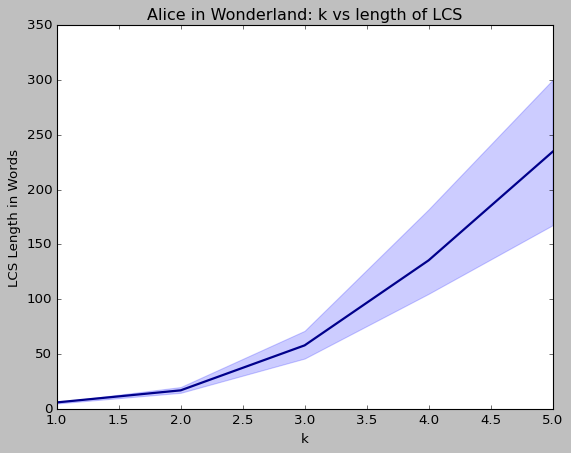

In [32]:
#plot for Wonderland book
plot_lcs_statistics(wonderland, "Alice in Wonderland", gen_lcs_statistics(wonderland))

In [33]:
#function to plot multiple k vs LCS length plots for different books

plot_colors = ["#009292", "#FF6DB6", "#490092", "#006DDB", "#B66DFF", "#6DB6FF", "#B6DBFF", "#920000", "#924900", "#DB6D00", "#24FF24", "#FFFF6D"]

def plot_many_lcs_statistics(list_of_dicts):

    fig, ax = plt.subplots(1, 1, figsize = (10,6))
    
    for i in range(len(list_of_dicts)):
        ax.plot(ks_to_plot, list_of_dicts[i]["stats"]["medians"], linewidth = 2, color = plot_colors[i], label=list_of_dicts[i]["book_name"])
        ax.fill_between(ks_to_plot, list_of_dicts[i]["stats"]["top_quartiles"], list_of_dicts[i]["stats"]["bot_quartiles"], color=plot_colors[i], alpha = 0.15)
        
    ax.set_ylim(0,350)
    ax.set_xlabel('k')
    ax.set_ylabel('LCS Length in Words')
    ax.set_title('k vs Length of LCS')
    ax.legend(loc = 'best')
    plt.show()


In [34]:
#generate statistics for all books
shakes_stats = gen_lcs_statistics(shakespeare)
metamorphosis_stats = gen_lcs_statistics(metamorphosis)
wonderland_stats = gen_lcs_statistics(wonderland)
monte_cristo_stats = gen_lcs_statistics(montecristo)

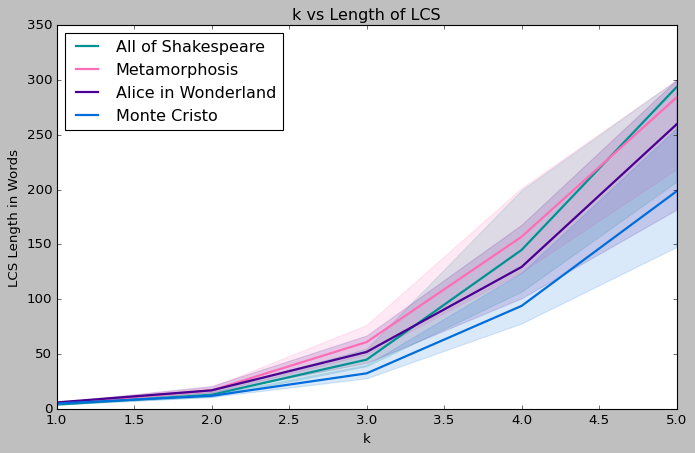

In [35]:
#plot for all books used in lab
plot_many_lcs_statistics(
    [
        {
            "book_name": "All of Shakespeare",
            "stats": shakes_stats
        }, {
            "book_name": "Metamorphosis",
            "stats": metamorphosis_stats
        }, {
            "book_name": "Alice in Wonderland",
            "stats": wonderland_stats
        }, {
            "book_name": "Monte Cristo",
            "stats": monte_cristo_stats
        }
    ]
)

Lastly, we are asked to come up with our own way of improving the LCS length of the model using a method we come up with or found via research (I found mine looking through documentation on impriving LCS length from *rdrr.io*. To improve the model's LCS length for a given k-gram length, I applied **temperature scaling** to adjust the probabilities of selecting the next word. By increasing the temperature value, I smoothed the probability distribution, making the model less likely to choose the most frequent word and more likely to explore other options. This approach aimed to reduce exact copying from the original text and create more diverse and original paragraphs while maintaining some coherence. I updated the `predict_next_word` function to incorporate temperature scaling and tested the effect on LCS lengths compared to the standard model.


In [36]:
# update predict next word function to include temperature scaling when assigning probabilities
def predict_next_word_temp_scaled(this_kgram, freq_dict):
    
    temp = 1.4
    
    if this_kgram not in freq_dict:
        return None
    else:
        total = 0
        nextWordOptions = []
        prob = []
        #find probability of each possible next word  
        for nextWord, count in freq_dict[this_kgram].items():
            total += count
        for nextWord,count in freq_dict[this_kgram].items():
            nextWordOptions.append(nextWord)
            prob.append(count/total)
        
        #recalc with temp
        probTemp = np.exp(np.log(prob) / temp)
        
        #normalize probs
        probTemp /= np.sum(probTemp)
        
        return random.choices(nextWordOptions, weights = probTemp, k = 1)[0]

In [37]:
# update gen paragraph function with new predict next word function
def predict_paragraph_temp_scaled(start_kgram, k, freq_dict, gen_length=300):

    gen_para = list(start_kgram)
    currKgram = " ".join(start_kgram)
    for i in range(gen_length-k):
        nextWord = predict_next_word_temp_scaled(currKgram, freq_dict)
        
        if nextWord is None:
            break
        gen_para.append(nextWord)
        currKgram = " ".join(gen_para[-k:])
    
    return gen_para

In [38]:
# test both methods on shakespeare. print two text examples with LCS length and then plot for 100 trials over all options for k

k_test = 3

freq_dict_test = make_freq_dict(k_test, shakespeare)

# pick a random starting k-gram from the freq-dict.
start_test = random.choice(list(freq_dict_test.keys())).split()

# Generate a paragraph, and print it.
gen_paragraph = predict_paragraph(start_test, k_test, freq_dict_test)
" ".join(gen_paragraph)

gen_paragraph_temp_scaled = predict_paragraph_temp_scaled(start_test, k_test, freq_dict_test)
" ".join(gen_paragraph_temp_scaled)

shakespeare_finder = LcsFinder(shakespeare)

# Use the LcsFinder to find the LCS length in the generated paragraph
print(f'LCS length original: {shakespeare_finder.lcs_length(gen_paragraph)} words')
print(f'LCS length temp scaled: {shakespeare_finder.lcs_length(gen_paragraph_temp_scaled)} words')
print()

# Use the LcsFinder to highlight substrings in the generated text that appear in the original text.
print('paragraph w/ no temp scaling:')
shakespeare_finder.greedy_lcs_markdown(gen_paragraph)
print('paragraph w/ temp scaling:')
shakespeare_finder.greedy_lcs_markdown(gen_paragraph_temp_scaled)  

LCS length original: 52 words
LCS length temp scaled: 42 words

paragraph w/ no temp scaling:


<font color=#009292>to me, practised upon the easy-yielding spirit of this woman, and made her</font> <font color=#FF6DB6>thrall To living death and pain perpetual, Which in her prescience she controlled still, But her foresight could not forestall their will. E’en in this thought</font> <font color=#490092>they find a kind of</font> <font color=#006DDB>colic pinch’d and vex’d By the imprisoning of unruly wind Within her womb, which for enlargement striving, Shakes the old beldam Earth, and topples down Steeples and moss-grown towers. At your birth Our grandam Earth, having this distemp’rature, In passion shook. GLENDOWER. Cousin, of many men I do not</font> <font color=#B66DFF>like to marry me</font> <font color=#920000>and make me Your fellow tribune. SICINIUS. You show too much of</font> <font color=#DB6D00>your own decay.— An honourable conduct let him have. Pembroke, look to ’t. Farewell, Chatillion. [_Exeunt Chatillion and Pembroke._] QUEEN ELEANOR. What now, my son! Have I not</font> <font color=#009292>made it. BELARIUS. Whither bound? IMOGEN. To Milford Haven. BELARIUS. What’s your name? IMOGEN. Fidele, sir.</font> <font color=#FF6DB6>CYMBELINE. Thou’rt my good youth, my page; I’ll be thy</font> <font color=#490092>second. [_Exeunt Sebastian and Antonio._] GONZALO. All three of them are desperate: their great guilt, Like poison given to work a great time after, Now ’gins to bite the spirits. I do beseech you That</font> <font color=#006DDB>for our crowned heads we have no</font> <font color=#B66DFF>great cause to give great thanks. SICINIUS. They are near the city? MESSENGER. Almost at point to</font> <font color=#920000>lose your liberties. Martius would have all</font> <font color=#DB6D00>as merry As, first, good company, good wine, good welcome Can make good people. Enter Lord Chamberlain, Lord Sandys and Sir Thomas Lovell.</font> <font color=#009292>What’s the matter? Enter Aeneas. AENEAS. Good morrow,</font> <font color=#FF6DB6>all. [_Exit with servant_.] PARIS. And tell me,</font> <font color=#490092>in the narrow seas</font> <font color=#006DDB>To give you over at this first encounter, Unless you will accompany me thither. GRUMIO. I pray you,</font> <font color=#B66DFF>what is he? SIR TOBY. He</font> <font color=#920000>shall think, by the</font> 

paragraph w/ temp scaling:


<font color=#009292>to me, practised upon the easy-yielding spirit of this woman, and made her</font> <font color=#FF6DB6>thrall To living death and pain perpetual, Which in her prescience she controlled still, But her foresight could not forestall their will. E’en in this thought</font> <font color=#490092>they find a kind of</font> <font color=#006DDB>auditor, one that hath abundance of charge too, God knows what. They are up already, and call for eggs and butter. They will away presently. GADSHILL. Sirrah, if they meet not with Saint Nicholas’ clerks, I’ll give thee</font> <font color=#B66DFF>thy due, and one that knows</font> <font color=#920000>the law, go to; and a</font> <font color=#DB6D00>fellow False as thy title to her. Friendship, blood, And all the</font> <font color=#009292>shrouds wherewith my life should sail Are turned to one thread, one little hair. My heart hath</font> <font color=#FF6DB6>melted at a lady’s tears, Being an ordinary inundation; But this effusion of such manly drops, This shower, blown up by tempest of the soul, Startles mine eyes and makes me more amaz’d Than had I seen the</font> <font color=#490092>haughty Cardinal, More like a</font> <font color=#006DDB>king, and privileged to speak. CLIFFORD. My liege, the</font> <font color=#B66DFF>Duke of Exeter, the Earl of</font> <font color=#920000>Worcester Hath broken his staff, resigned his stewardship, And all the</font> <font color=#DB6D00>conduits of my blood</font> <font color=#009292>He’ll breed revengement and a scourge for me; But thou dost in thy passages of life Make me believe that thou art</font> <font color=#FF6DB6>poor. Hold, there is</font> <font color=#490092>the very top, The height, the crest, or crest unto the crest, Of murder’s arms. This is the</font> <font color=#006DDB>hag, when maids lie on their backs, That presses them, and learns them first to bear, Making them women of good carriage: This is she,— ROMEO. Peace, peace, Mercutio, peace, Thou talk’st of nothing. MERCUTIO. True, I talk of</font> <font color=#B66DFF>you. Why did you wish me milder? Would you have</font> <font color=#920000>me— If you have</font> <font color=#DB6D00>done me much ungentleness To show the</font> 

In [39]:
#testing using a large sample size of generated paragraphs to evaluate effectiveness of temperature scling here
# get average difference across 100 tests - turns out this doesn't really work
tests = 150

shakespeare_finder = LcsFinder(shakespeare)
tempTotalLCS = 0
origTotalLCS = 0
totalDiff = 0

for i in range(tests):
    start_test = random.choice(list(freq_dict_test.keys())).split()
    gen_paragraph = predict_paragraph(start_test, k_test, freq_dict_test)
    " ".join(gen_paragraph)

    gen_paragraph_temp_scaled = predict_paragraph_temp_scaled(start_test, k_test, freq_dict_test)
    " ".join(gen_paragraph_temp_scaled)
    
    origTotalLCS += shakespeare_finder.lcs_length(gen_paragraph)
    tempTotalLCS += shakespeare_finder.lcs_length(gen_paragraph_temp_scaled)

avgOrigLCS = origTotalLCS/tests
avgTempLCS = tempTotalLCS/tests

avgDiff = avgOrigLCS - avgTempLCS

print("average LCS length Original: " + str(avgOrigLCS))
print("average LCS length TempScaled: " + str(avgTempLCS))
print("average difference: " + str(avgDiff))

average LCS length Original: 48.94
average LCS length TempScaled: 50.00666666666667
average difference: -1.06666666666667


Ultimately, the temperature scaling approach did not work particularly well. This method likely didn't improve LCS length because, while it introduces more variability in word choice, it doesn't fundamentally change the structure of the generated text. The model still relies heavily on the k-gram frequencies from the original text, meaning that it can still copy long segments if they are common enough. Additionally, increasing temperature too much may disrupt grammatical coherence without sufficiently reducing copying, leading to incoherent but still plagiaristic text. Therefore, more sophisticated methods beyond temperature scaling are needed to balance originality and structure effectively.
 